# Henon-Heiles system

0    0    1    0

0    0    0    1

-1   0    0    0

0    -1   0    0
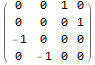

In [1]:
V[x_, y_] := 1/2 (x^2 + y^2 + 2 x^2 y - 2/3 y^3);

H[{x_, y_, px_, py_}] := 1/2 (px^2 + py^2) + V[x, y];

J = Normal[SparseArray[{{1, 3}, {2, 4}, {3, 1}, {4, 2}} -> {1, 1, -1, -1}, {4, 4}]];
J // MatrixForm

In [5]:
dX = D[{x[t], y[t], px[t], py[t]},t];

DH = D[H[{x[t], y[t], px[t], py[t]}], {{x[t], y[t], px[t], py[t]}}] // Simplify;

eqns = #[[1]] == #[[2]]& /@ Transpose[{dX, J.DH}]

{x'[t] == px[t], y'[t] == py[t], px'[t] == -(x[t] (1 + 2 y[t])), 
 
                   2              2
>   py'[t] == -x[t]  - y[t] + y[t] }

In [8]:
Initcond[x_, {y_, py_}, Energy_] :=
    NSolve[{H[{x, y, px0, py}]} == Energy, px0]

Initcond[0, {0.5, 0.4}, 1/6]

{{px0 -> -0.0816497}, {px0 -> 0.0816497}}

In [10]:
SolveHamiltonianFlow[x0_, {y0_, py0_}, Energy_, tmax_] := 
    Module[
        {px0 = px0 /. (Take[Initcond[x0, {y0, py0}, Energy], 1][[1]])},
        Flatten[{x, y, px, py} /. NDSolve[{
        eqns,
        x[0] == x0,
        y[0] == y0,
        px[0] == px0,
        py[0] == py0
        },
        {x, y, px, py}, 
        {t, 0, tmax}, 
        Method -> {"ExplicitRungeKutta", "DifferenceOrder" -> 8},
        InterpolationOrder -> All, 
        AccuracyGoal -> 14,
        PrecisionGoal -> 14, 
        MaxSteps -> Infinity
        ]
        ]
    ]

In [11]:
traj = SolveHamiltonianFlow[0, {0.5, 0.4}, 1/6, 400];

-Graphics-
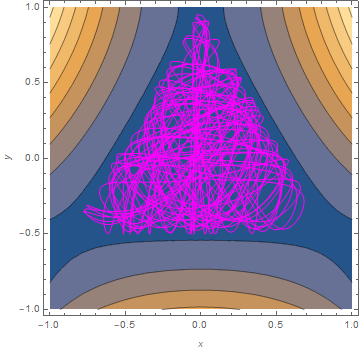

In [12]:
Show[{
    ContourPlot[V[x, y], {x, -1, 1}, {y, -1, 1}, FrameLabel -> Automatic],
    ParametricPlot[{traj[[1]][t], traj[[2]][t]}, {t, 0, 400}, PlotStyle -> Magenta, Frame -> True, Axes -> False, AspectRatio -> 1]
    }]

In [13]:
(* Making randam uniform data at Poincare Section, x0 = 0 
Return : {y0, py0, px0}
*)
MultiSampleData[ymax_, {Pymin_, Pymax_}, Energy_, samplenum_] :=
    Module[
        {\[CapitalOmega], Alldatapts, col, x0 = 0, sampling},
        \[CapitalOmega] = Rectangle[{-ymax, Pymin}, {ymax, Pymax}];
        SeedRandom[1234];
        sampling = RandomPoint[\[CapitalOmega], samplenum];
        Alldatapts = {#[[1]], #[[2]], px0} /. RandomChoice[Initcond[x0, {#[[1]], #[[2]]}, Energy]] & /@ sampling;
        Select[Alldatapts, MatchQ[#[[3]], _Real] &]
    ]

In [15]:
MultiSampleData[1.0, {-0.8, 0.8}, 1/6, 10]

{{0.753217, 0.0351428, -0.222816}, {0.0875135, -0.0330693, 0.570112}, 
 
>   {0.167709, -0.377643, 0.407109}, {0.83912, -0.121864, -0.0908602}}

In [16]:
Poincare[x0_, {y0_, py0_, px0_}, Energy_, tmax_] := 
    Module[
        {},
        If[# == {}, {}, First[#]] &@Last[Reap[
            NDSolve[{
                eqns,
                x[0] == x0,
                y[0] == y0,
                px[0] == px0,
                py[0] == py0
                },
                {(*empty*)}, 
                {t, 0, tmax},
                Method -> {"EventLocator", "Event" -> x[t],
                            "EventCondition" -> (px[t] > 0), 
                            "EventAction" :> Sow[{y[t], py[t], t}],
                            "EventLocationMethod" -> "LinearInterpolation"(* for Poincare plot *), 
                            "Method" -> {"ExplicitRungeKutta", "DifferenceOrder" -> 8}},
                InterpolationOrder -> All, 
                AccuracyGoal -> 14,
                PrecisionGoal -> 14, 
                MaxSteps -> Infinity
            ]
        ]]
    ]
    
PlotsPoincare[Energy_, tmax_, plotnum_] := 
    Module[
        {mpts, Sectionpts, Sectiontime, DtimeSet},
        mpts = RandomChoice[MultiSampleData[1.0, {-0.8, 0.8}, Energy, 10^4], plotnum];
        Print[{Length[mpts], Max[H[{0, #1, #3, #2}] & @@@ mpts]}];
        (* initialize *)
        SetSharedVariable[SectionptsSet];
        SectionptsSet = Parallelize[Poincare[0, {Sequence @@ #}, Energy, tmax] & /@ mpts];
        Sectionpts = Take[#, All, 2] & /@ (Select[SectionptsSet, UnsameQ[#, {}] &]);
        (*Sectiontime = Flatten[#] & /@ (Take[#, All, -1] & /@ (Select[SectionptsSet, UnsameQ[#, {}] &]));
        DtimeSet = (#[[2 ;; -1]] - #[[1 ;; -2]]) & /@ Sectiontime;
        MeanDynamicalTime = Mean[#] & /@ DtimeSet;*)
        Labeled[Show[
            ListPlot[
                #1,
                PlotStyle -> {PointSize[.005], Darker[Hue[N[#2/plotnum]], 0.1]}, 
                AspectRatio -> 1,
                Axes -> False, 
                AspectRatio -> Automatic, 
                Frame -> True,
                PlotLabel -> TraditionalForm[e == Energy/. Rational[n_, d_] :> InputForm[n/d]],
                ImageSize -> 300
            ] & @@@ Transpose[{Sectionpts, Range[1, plotnum]}],
            PlotRange -> All], 
            {y, py}, 
            {Bottom, Left}
        ]
    ]

{KernelObject[1, local], KernelObject[2, local], KernelObject[3, local], 
 
>   KernelObject[4, local], KernelObject[5, local], KernelObject[6, local]}
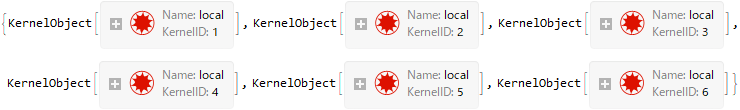

In [19]:
LaunchKernels[]

{120, 0.01}
{120, 0.0833333}
{120, 0.125}
{120, 0.166667}


{Labeled[-Graphics-, {y, py}, {Bottom, Left}], 
 
>   Labeled[-Graphics-, {y, py}, {Bottom, Left}], 
 
>   Labeled[-Graphics-, {y, py}, {Bottom, Left}], 
 
>   Labeled[-Graphics-, {y, py}, {Bottom, Left}]}
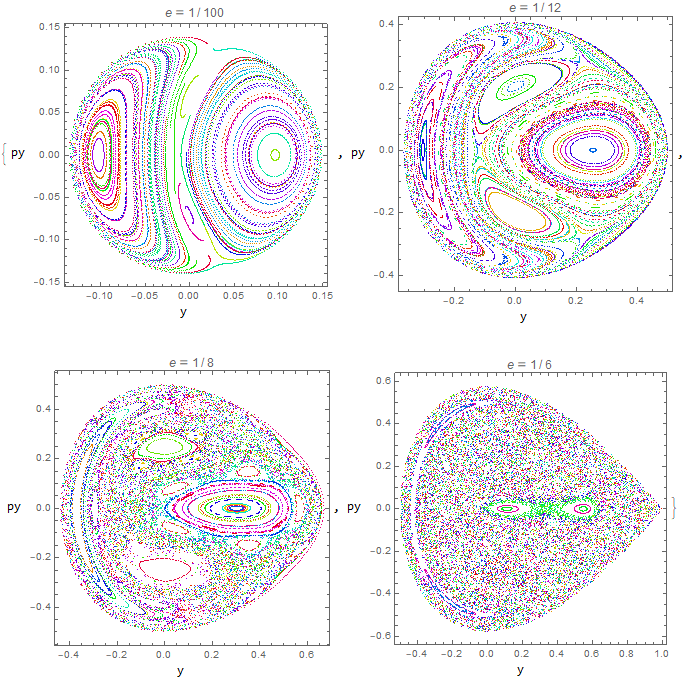

In [20]:
Show[PlotsPoincare[#, 1000, 120]]& /@ {1/100, 1/12, 1/8, 1/6}

{KernelObject[0, local, <defunct>], KernelObject[0, local, <defunct>], 
 
>   KernelObject[0, local, <defunct>], KernelObject[0, local, <defunct>], 
 
>   KernelObject[0, local, <defunct>], KernelObject[0, local, <defunct>]}
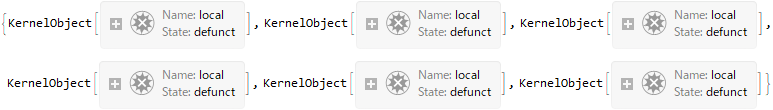

In [21]:
CloseKernels[]

# Lyapunov Spectrum

0             0             1             0

0             0             0             1

-1 - 2 y[t]   -2 x[t]       0             0

-2 x[t]       -1 + 2 y[t]   0             0
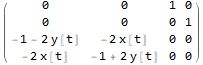

In [67]:
(* Hessian matrix \[Del]^2H *)
DDH = D[H[{x[t], y[t], px[t], py[t]}], {{x[t], y[t], px[t], py[t]}, 2}] // Simplify;

J.DDH//MatrixForm

{x'[t] == px[t], y'[t] == py[t], px'[t] == -(x[t] (1 + 2 y[t])), 
 
                   2              2
>   py'[t] == -x[t]  - y[t] + y[t] , 
 
>   (w[1])'[t] == {{0, 0, 1, 0}, {0, 0, 0, 1}, {-1 - 2 y[t], -2 x[t], 0, 0}, 
 
>      {-2 x[t], -1 + 2 y[t], 0, 0}} . w[1][t], 
 
>   (w[2])'[t] == {{0, 0, 1, 0}, {0, 0, 0, 1}, {-1 - 2 y[t], -2 x[t], 0, 0}, 
 
>      {-2 x[t], -1 + 2 y[t], 0, 0}} . w[2][t], 
 
>   (w[3])'[t] == {{0, 0, 1, 0}, {0, 0, 0, 1}, {-1 - 2 y[t], -2 x[t], 0, 0}, 
 
>      {-2 x[t], -1 + 2 y[t], 0, 0}} . w[3][t], 
 
>   (w[4])'[t] == {{0, 0, 1, 0}, {0, 0, 0, 1}, {-1 - 2 y[t], -2 x[t], 0, 0}, 
 
>      {-2 x[t], -1 + 2 y[t], 0, 0}} . w[4][t]}
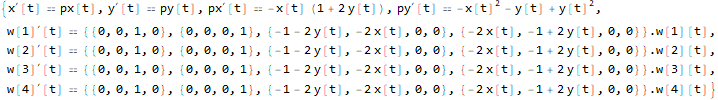

In [70]:
JacobiMat = J.DDH;

lyapeqns = Join[eqns, Table[Derivative[1][w[i]][t] == JacobiMat.w[i][t], {i, 1, 4}]]

In [75]:
LyapunovExponents[x0_, {y0_, py0_, px0_}, tmax_, \[CapitalDelta]t_] := 
    Module[
        {step = 1, norm = 0, sum = 0, gs},
        \[Lambda]all = Table[{}, {4}];
        NDSolve[
            {
            lyapeqns,
            x[0] == x0,
            y[0] == y0,
            px[0] == px0,
            py[0] == py0,
            w[1][0] == {1, 1, 1, 1},
            w[2][0] == {-1, -1, 1, 1},
            w[3][0] == {1, -1, -1, 1},
            w[4][0] == {-1, 1, -1, 1},
            WhenEvent[
                Mod[t, \[CapitalDelta]t] == 0, 
                {norm = Norm[#] & /@ (#[t] & /@ (Array[w, 4])),
                sum = sum + Log[norm],
                \[Lambda]all = Join[\[Lambda]all, Partition[sum/(step*\[CapitalDelta]t), 1], 2],
                gs = Orthogonalize[{w[1][t], w[2][t], w[3][t], w[4][t]}, Method -> "GramSchmidt"],
                w[1][t] -> gs[[1]],
                w[2][t] -> gs[[2]],
                w[3][t] -> gs[[3]],
                w[4][t] -> gs[[4]],
                (*normtmp={w[1][t].w[2][t],w[2][t].w[3][t],w[3][t].w[4][t],w[4][t].w[1][t],w[4][t].w[2][t],w[1][t].w[3][t],w[4][t].w[4][
                  t]},(*Norm[#]&/@gs,*)
                  If[step<50&&Mod[step,2]\[Equal]0(*step\[Equal]1||Mod[step,
                  50]\[Equal]0*),Print[Style[{step,Max[Abs[gs.Transpose[gs]-
                  IdentityMatrix[4]]],sum,normtmp}]]],*)
                step++
                }
            ]
            },
            {}, 
            {t, 0, tmax},
            Method -> {"ExplicitRungeKutta", "DifferenceOrder" -> 8},
            InterpolationOrder -> All, 
            AccuracyGoal -> 14, 
            PrecisionGoal -> 14,
            MaxSteps -> Infinity
        ];
        Table[\[Lambda]all[[i]][[-1]], {i, 4}]
    ]

In [73]:
initdata = MultiSampleData[1.0, {-0.8, 0.8}, 1/6, 10]

{{0.753217, 0.0351428, -0.222816}, {0.0875135, -0.0330693, 0.570112}, 
 
>   {0.167709, -0.377643, 0.407109}, {0.83912, -0.121864, -0.0908602}}

In [77]:
AbsoluteTiming[LyapunovExponents[0, initdata[[1]], 1000, 0.01]]

{374.694, {0.134555, 0.00887358, -0.00476085, -0.129643}}

{Labeled[-Graphics-, Text[normalize steps]], Labeled[-Graphics-, Text[normalize steps]]}
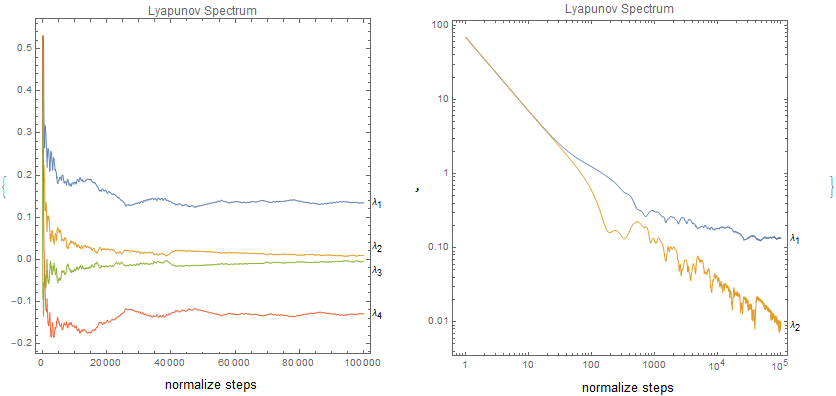

In [86]:
{
    Labeled[
    ListLinePlot[
        MapThread[Labeled[#1, #2] &, {\[Lambda]all, Subscript[\[Lambda],#]& /@ Range[1, 4, 1]}],
        PlotStyle -> PointSize[.005],
        Axes -> False,
        AspectRatio -> 1,
        Frame -> True,
        ImageSize -> 400,
        PlotLabel -> "Lyapunov Spectrum"
    ], Text["normalize steps"]
    ],
    
    Labeled[
    ListLinePlot[
        MapThread[Labeled[#1, #2] &, {Take[\[Lambda]all,2], Subscript[\[Lambda],#]& /@ Range[1, 2, 1]}],
        PlotStyle -> PointSize[.005],
        Axes -> False,
        AspectRatio -> 1,
        Frame -> True,
        ImageSize -> 400,
        ScalingFunctions -> {"Log", "Log"},
        PlotLabel -> "Lyapunov Spectrum"
    ], Text["normalize steps"]
    ]
}